# **HỆ THỐNG GỢI Ý PHIM - MOVIE RECOMMENDATION SYSTEM**

# Tổng quan và các hướng tiếp cận với bài toán Hệ thống gợi ý

Bài toán  Hệ thống gợi ý đã có lịch sử từ những năm 90s, với những paper đầu tiên liên quan đến lọc bằng nội dung (content-based filtering). Xuất phát từ những nhu cầu khi người dùng cần những gợi ý mang tính cá nhân hóa, và cho đến khi Internet xuất hiện, cụ thể là Google, các sàn thương mại điện tử,... giới nghiên cứu đã chú ý hơn và tìm nhiều hướng phát triển nó, với một số ý tưởng mượn từ lĩnh vực truy vấn thông tin (Information Retrieval), kết hợp lý thuyết học máy, thống kê.

Vân đề chủ yếu thường được xem xét là với input là một user, hãy đề xuất những item mà người đó có thể ưa thích.

 Có 3 hướng tiếp cận chính:
- Content-based filtering (lọc bằng nội dung)
- Collaborative filtering (lọc dựa trên cộng tác)
- Hybrid method (phương pháp kết hợp)

Sau đây là sơ lược về các hướng tiếp cận trên, cũng như nhược điểm của chúng:
1.  **Content-based filtering**
+ Content-based tiếp cận bằng cách từ những sản phẩm (item) mà người dùng (user) đã đánh giá trong quá khứ, đề xuất những item tương tự với item đó
+ Một cách điển hình là biểu diễn item hoặc user bởi vector embedding để có thể nhìn thấy được sự tương tự giữa chúng
+ Nhược điểm có thể nhìn thấy ngay là nếu input là một user mới chưa có đánh giá item nào thì không thể đề xuất item nào cho người đó. Bên cạnh đó, nếu cứ mãi đề xuất những item tương tự nhau thì rất nhàm chán!
+ Ưu điểm là với một item mới (sàn thương mại điện tử) thì đây có thể là một giải pháp đem lại hiệu quả.
2.  **Collaborative filtering**
+ Collaborative tiếp cận bằng cách nhóm các user tương tự nhau lại, đề xuất item mà những user trong nhóm này ưa thích cho user cần xét
+ Điển hình là thuật KNN, SVD,...
+ Nhược điểm phương pháp này khá nhiều. Thứ nhất, với một item mới (hoặc item lạ, không nổi bật) thì đang có rất ít user đánh giá nó, dẫn đến nó rất khó có thể reach out (được gợi ý) đến user. Thứ hai, một user mới bước vào hệ thống, chưa có nhiều thông tin về preference của user này (chính là những đánh giá) dẫn đến khó có thể phân nhóm cho họ. Để xứ lý, có thể nghĩ đến cách sử dụng thông tin nhân khẩu (demographic, meta data) để thực hiện gom nhóm
3.  **Hybrid method**
+ Hướng tiếp cận này kết hợp được cả tính chất của 2 hướng trên, sẽ được đề cập cụ thể ở notebook sau

# Phần 1: Explore Data Analysis

## 1. Thư viện cần thiết

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
import copy
import tqdm
!pip install surprise
from surprise import Reader,Dataset,SVD,accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from collections import Counter
from google.colab import drive
drive.mount('/content/drive')

## 2. Đọc dữ liệu

In [ ]:
ratings = pd.read_csv(r"drive/My Drive/ratings.dat", sep = "::", encoding="cp1252")
ratings.columns = ['userid', 'movieid', 'rating', 'timestamp']
movies = pd.read_csv(r"drive/My Drive/movies.dat", sep = "::", encoding="cp1252")
movies.columns = ['movieid', 'title', 'genres']
users = pd.read_csv(r"drive/My Drive/users.dat", sep = "::", encoding="cp1252")
users.columns = ['userid','gender','age','occupation','zip-code']

## 3.  Một số phân tích về dữ liệu ratings

In [ ]:
ratings

,userid,movieid,rating,timestamp
0,1,661,3,978302109
1,1,914,3,978301968
2,1,3408,4,978300275
3,1,2355,5,978824291
4,1,1197,3,978302268
...,...,...,...,...
1000203,6040,1091,1,956716541
1000204,6040,1094,5,956704887
1000205,6040,562,5,956704746
1000206,6040,1096,4,956715648


a) Kiểm tra có giá trị rỗng (null) không

In [ ]:
ratings['userid'].isnull().sum()
ratings['movieid'].isnull().sum()
ratings['rating'].isnull().sum()
ratings['timestamp'].isnull().sum()

0

b) Kiểm tra và loại bỏ các giá trị rating không hợp lệ (Giá trị hợp lệ từ 1 tới 5)

In [ ]:
ratings = ratings[(ratings['rating'] >= 1) & (ratings['rating'] <= 5)]
ratings

,userid,movieid,rating,timestamp
0,1,661,3,978302109
1,1,914,3,978301968
2,1,3408,4,978300275
3,1,2355,5,978824291
4,1,1197,3,978302268
...,...,...,...,...
1000203,6040,1091,1,956716541
1000204,6040,1094,5,956704887
1000205,6040,562,5,956704746
1000206,6040,1096,4,956715648


 c) Tính trung bình, trung vị, tứ phân vị của cột rating

In [ ]:
mean_rating = ratings['rating'].mean()
median_rating = ratings['rating'].median()
q1 = ratings['rating'].quantile(0.25)
q3 = ratings['rating'].quantile(0.75)

print(f'Mean Rating: {mean_rating}')
print(f'Median Rating: {median_rating}')
print(f'First Quartile (Q1): {q1}')
print(f'Third Quartile (Q3): {q3}')

Mean Rating: 3.581563034888743
Median Rating: 4.0
First Quartile (Q1): 3.0
Third Quartile (Q3): 4.0


d) Biểu đồ cột rating

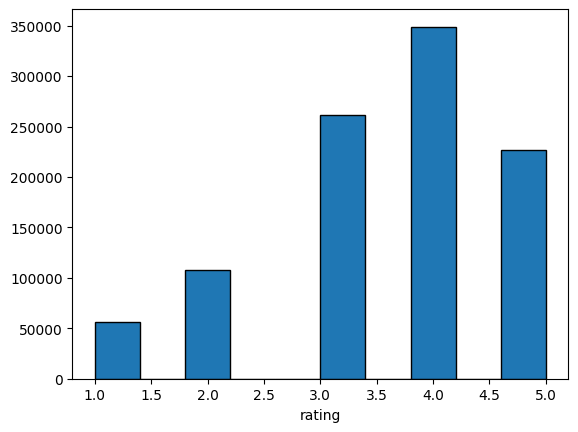

In [ ]:
plt.hist(ratings['rating'], bins=10, edgecolor='black')

plt.xlabel('rating')
plt.show()

 **Nhận xét**: Có thể thấy phần nhiều các bộ phim đều được đánh giá trên 3 sao, khá ổn. 4 sao chiếm số lượng nhiều nhất

e) Biểu đồ hộp về rating để kiểm tra xem có outlier không

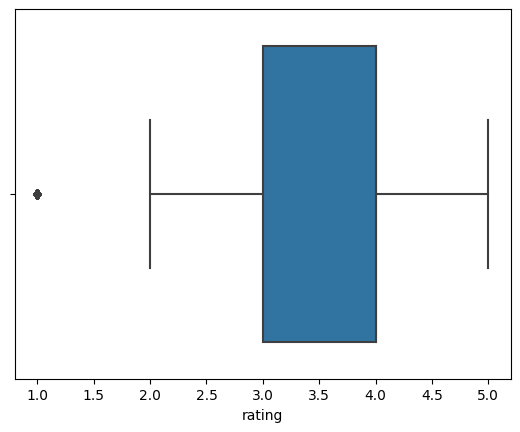

In [ ]:
sns.boxplot(x=ratings['rating'])
plt.show()

 **Nhận xét**: Biểu đồ hộp cho thấy chỉ có 1 outlier duy nhất, có nghĩa là số liệu rating khá là chặt chẽ và tốt

---



## 4. Một số phân tích về dữ liệu movie

 Mục đích:
- Để phân tích sự phân bố thời gian sản xuất phim.
- Để thống kê tỉ lệ các bộ phim hay sản xuất các thể loại nào.

In [ ]:
movies

,movieid,title,genres
0,2,Jumanji (1995),Adventure|Children's|Fantasy
1,3,Grumpier Old Men (1995),Comedy|Romance
2,4,Waiting to Exhale (1995),Comedy|Drama
3,5,Father of the Bride Part II (1995),Comedy
4,6,Heat (1995),Action|Crime|Thriller
...,...,...,...
3877,3948,Meet the Parents (2000),Comedy
3878,3949,Requiem for a Dream (2000),Drama
3879,3950,Tigerland (2000),Drama
3880,3951,Two Family House (2000),Drama


a) Kiểm tra movies dataframe có giá trị rỗng không

In [ ]:
movies['movieid'].isnull().sum()
movies['title'].isnull().sum()
movies['genres'].isnull().sum()

0

b) Biểu đồ phân bố các phim theo năm

In [ ]:
movies['year'] = movies['title'].str[-5:-1].astype(int)
movies['title'] = movies['title'].str[:-7]
movies

,movieid,title,genres,year
0,2,Jumanji,Adventure|Children's|Fantasy,1995
1,3,Grumpier Old Men,Comedy|Romance,1995
2,4,Waiting to Exhale,Comedy|Drama,1995
3,5,Father of the Bride Part II,Comedy,1995
4,6,Heat,Action|Crime|Thriller,1995
...,...,...,...,...
3877,3948,Meet the Parents,Comedy,2000
3878,3949,Requiem for a Dream,Drama,2000
3879,3950,Tigerland,Drama,2000
3880,3951,Two Family House,Drama,2000


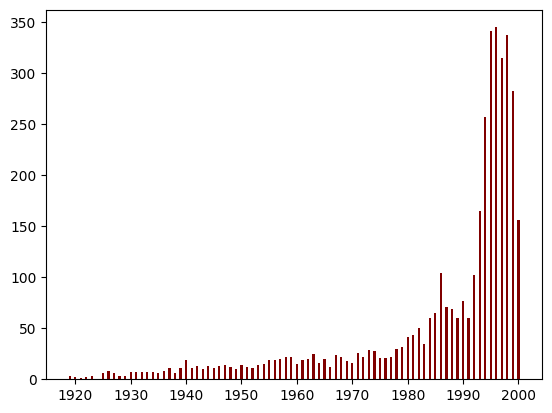

In [ ]:
test = Counter(movies['year'])
x = test.keys()
y = test.values()

plt.bar(x,y, color ='maroon', width = 0.4)
plt.show()

 **Nhận xét**: Các bộ phim trong movies dataframe được sản xuất trước năm 1980 khá là ít nhưng sau năm 1990 phim được sản xuất ngày càng nhiều, vì công nghệ làm phim đã phát triển và nhu cầu xem phim ngày càng tăng.

c) Chia thuộc tính genres (thể loại) thành nhiều cột có thể loại khác nhau để phân tích

In [ ]:
def extract_info(string):
    x = re.split(" \((\d{4})\)$",string)
    return x[:2]

In [ ]:
def genre_extract(string):
    return re.split("\|",string)

In [ ]:
def all_genre_creating(movies):
    uniqe_genres = []
    for string in movies['genres']:
        array = genre_extract(string)
        for genre in array:
            if genre not in uniqe_genres and genre != '(no genres listed)':
                uniqe_genres.append(genre)
    return uniqe_genres

In [ ]:
def movie_profiling(movies):
    uniqe_genres = all_genre_creating(movies)
    movie_profile = copy.deepcopy(movies)
    for genre in uniqe_genres :
        movie_profile[genre] = 0
    loc = 0
    for string in movie_profile['genres']:
        for genre in genre_extract(string):
            if genre in uniqe_genres:
                movie_profile[genre].iloc[loc] = 1
        loc = loc + 1

    movie_profile = movie_profile.drop(columns=['title', 'genres']).set_index('movieid')
    return movie_profile

In [ ]:
movie_profile = movie_profiling(movies)
movie_profile

,Adventure,Children's,Fantasy,Comedy,Romance,Drama,Action,Crime,Thriller,Horror,Animation,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
movieid,,,,,,,,,,,,,,,,,,
2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3949,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3950,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


**Nhận xét**: Giá trị 1 là bộ phim có sử dụng thể loại, 0 là bộ phim không có thể loại đó

 d) Vẽ biểu đồ tròn để phân tích các bộ phim thường sản xuất theo thể loại gì

In [ ]:
genre_counts = movie_profile.sum()
print(genre_counts)

Adventure       283
Children's      250
Fantasy          68
Comedy         1199
Romance         471
Drama          1603
Action          503
Crime           211
Thriller        492
Horror          343
Animation       104
Sci-Fi          276
Documentary     127
War             143
Musical         114
Mystery         106
Film-Noir        44
Western          68
dtype: int64


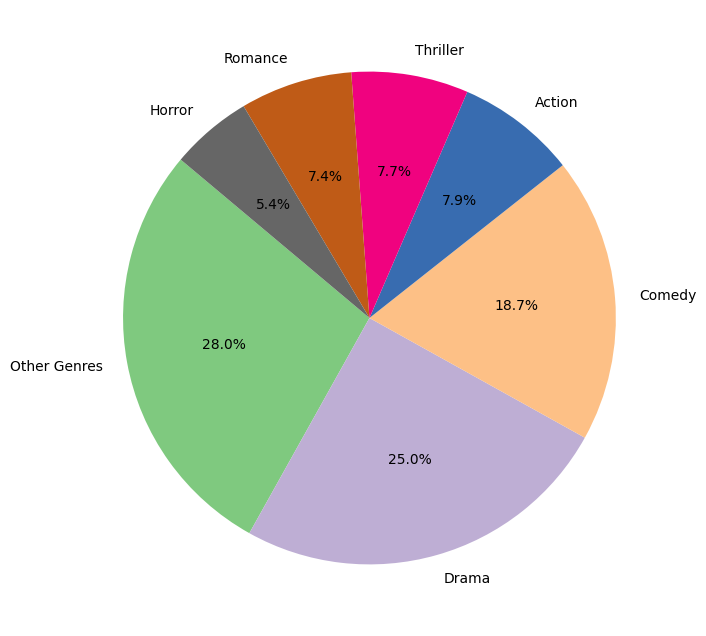

In [ ]:
labels = genre_counts.index
sizes = genre_counts.values
total_count = sizes.sum()

threshold_percentage = 5
small_genres = sizes / total_count * 100 < threshold_percentage
other_genres_count = sizes[small_genres].sum()
mask_large_genres = ~small_genres

labels = labels[mask_large_genres].tolist() + ['Other Genres']
sizes = sizes[mask_large_genres].tolist() + [other_genres_count]

sorted_indices = sorted(range(len(sizes)), key=lambda k: sizes[k], reverse=True)
labels = [labels[i] for i in sorted_indices]
sizes = [sizes[i] for i in sorted_indices]

colormap = cm.get_cmap('Accent', len(labels))

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colormap(range(len(labels))))
plt.show()

**Nhận xét**: Dựa vào biểu đồ, có thể thấy hai thể loại Drama và Comedy là hai thể loại được nhiều người dùng quan tâm.

## Một số phân tích về dữ liệu users

 Mục đích:
 - Thống kê về số lượng rating theo giới tính và thể loại
 - Để tìm ra người dùng ở độ tuổi nào thích xem phim thể loại gì

In [ ]:
bins = [0, 25, 30, 45, float('inf')]
labels = ['<=24', '25-30', '31-45', '>=45']

users['age_bin'] = pd.cut(users['age'], bins=bins, labels=labels, right=False)
users = users[['userid', 'gender', 'age', 'occupation', 'zip-code','age_bin']]
users

,userid,gender,age,occupation,zip-code,age_bin
0,2,M,56,16,70072,>=45
1,3,M,25,15,55117,25-30
2,4,M,45,7,02460,>=45
3,5,M,25,20,55455,25-30
4,6,F,50,9,55117,>=45
...,...,...,...,...,...,...
6034,6036,F,25,15,32603,25-30
6035,6037,F,45,1,76006,>=45
6036,6038,F,56,1,14706,>=45
6037,6039,F,45,0,01060,>=45


In [ ]:
users['userid'].isnull().sum()
users['gender'].isnull().sum()
users['age'].isnull().sum()
users['occupation'].isnull().sum()
users['zip-code'].isnull().sum()

0

a) Ghép hai df users và rating lại thành một

In [ ]:
merged_data = pd.merge(ratings, users[['userid', 'gender', 'age_bin']], on='userid')

ratings_users = merged_data[['userid', 'gender', 'age_bin', 'movieid', 'rating']]
ratings_users

,userid,gender,age_bin,movieid,rating
0,2,M,>=45,1357,5
1,2,M,>=45,3068,4
2,2,M,>=45,1537,4
3,2,M,>=45,647,3
4,2,M,>=45,2194,4
...,...,...,...,...,...
1000151,6040,M,25-30,1091,1
1000152,6040,M,25-30,1094,5
1000153,6040,M,25-30,562,5
1000154,6040,M,25-30,1096,4


 b) Tính toán điểm rating trung bình của phim dựa trên độ tuổi và giới tính


In [ ]:
merged_data = pd.merge(ratings_users, movie_profile, on='movieid')
movie_avg_ratings = merged_data.groupby(['movieid', 'age_bin', 'gender'])['rating'].mean().reset_index()
movie_avg_ratings

,movieid,age_bin,gender,rating
0,2,<=24,F,3.103448
1,2,<=24,M,3.053030
2,2,25-30,F,3.352941
3,2,25-30,M,3.095238
4,2,31-45,F,3.400000
...,...,...,...,...
29635,3952,25-30,M,3.766355
29636,3952,31-45,F,3.500000
29637,3952,31-45,M,3.781818
29638,3952,>=45,F,4.000000


 c) Từ phần b, Tính toán điểm rating trung bình của các thể loại dựa trên độ tuổi và giới tính, và điểm trung bình phim

In [ ]:
merged_data = pd.merge(movie_avg_ratings, movie_profile, on='movieid')
melted_df = pd.melt(merged_data, id_vars=['age_bin', 'gender', 'movieid', 'rating'], var_name='genre', value_name='genre_value')
filtered_df = melted_df[melted_df['genre_value'] == 1]
genres_ratings = filtered_df.groupby(['age_bin', 'gender', 'genre'])['rating'].mean().reset_index()

genres_ratings

,age_bin,gender,genre,rating
0,<=24,F,Action,2.957983
1,<=24,F,Adventure,3.086805
2,<=24,F,Animation,3.362932
3,<=24,F,Children's,3.071854
4,<=24,F,Comedy,3.221092
...,...,...,...,...
139,>=45,M,Romance,3.342208
140,>=45,M,Sci-Fi,3.114290
141,>=45,M,Thriller,3.278739
142,>=45,M,War,3.674794


d) Tạo dataframe (genre_data) thống kê về điểm trung bình của các thể loại dựa trên độ tuổi và giới tính

In [ ]:
genre_data = genres_ratings.pivot_table(index=['age_bin', 'gender'], columns='genre', values='rating', aggfunc='mean')
genre_data = genre_data.drop(columns=genre_data.filter(like='Film-Noir').columns)
genre_data.reset_index(inplace=True)

genre_data

genre,age_bin,gender,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,<=24,F,2.957983,3.086805,3.362932,3.071854,3.221092,3.343403,3.831511,3.433037,3.063737,2.760251,3.523932,3.442150,3.381224,3.014737,3.125262,3.483695,3.230412
1,<=24,M,3.109898,3.003829,3.229570,2.761746,3.095603,3.362664,3.506409,3.299284,3.006655,2.791237,3.020058,3.385396,3.219917,3.071853,3.194792,3.515644,3.229569
2,25-30,F,3.078027,3.106851,3.406673,3.147753,3.233104,3.383203,3.837103,3.485803,3.231734,2.648175,3.664375,3.423702,3.416299,2.933501,3.252150,3.567798,3.326724
3,25-30,M,3.049853,3.035352,3.322708,2.872709,3.091346,3.375691,3.746593,3.380369,2.966147,2.782345,3.332163,3.456514,3.241651,3.067979,3.241516,3.498322,3.585052
4,31-45,F,3.181350,3.282265,3.385342,3.337272,3.325984,3.400665,3.586618,3.554419,3.308343,2.765857,3.618970,3.434627,3.510797,3.098179,3.191325,3.692762,3.511244
5,31-45,M,3.137080,3.132654,3.359943,3.043839,3.144945,3.392256,3.960466,3.470109,3.063765,2.731978,3.402061,3.384523,3.331332,3.084555,3.271734,3.554284,3.486056
6,>=45,F,3.195497,3.259405,3.542743,3.289824,3.284359,3.456798,3.943208,3.630953,3.322904,2.803500,3.607080,3.576449,3.508619,3.068172,3.354346,3.724020,3.503725
7,>=45,M,3.122996,3.178601,3.393141,3.088076,3.203636,3.432480,3.590276,3.524035,3.210034,2.566405,3.509611,3.461561,3.342208,3.114290,3.278739,3.674794,3.495592


 e) Thống kê về số lượng rating theo giới tính và thể loại

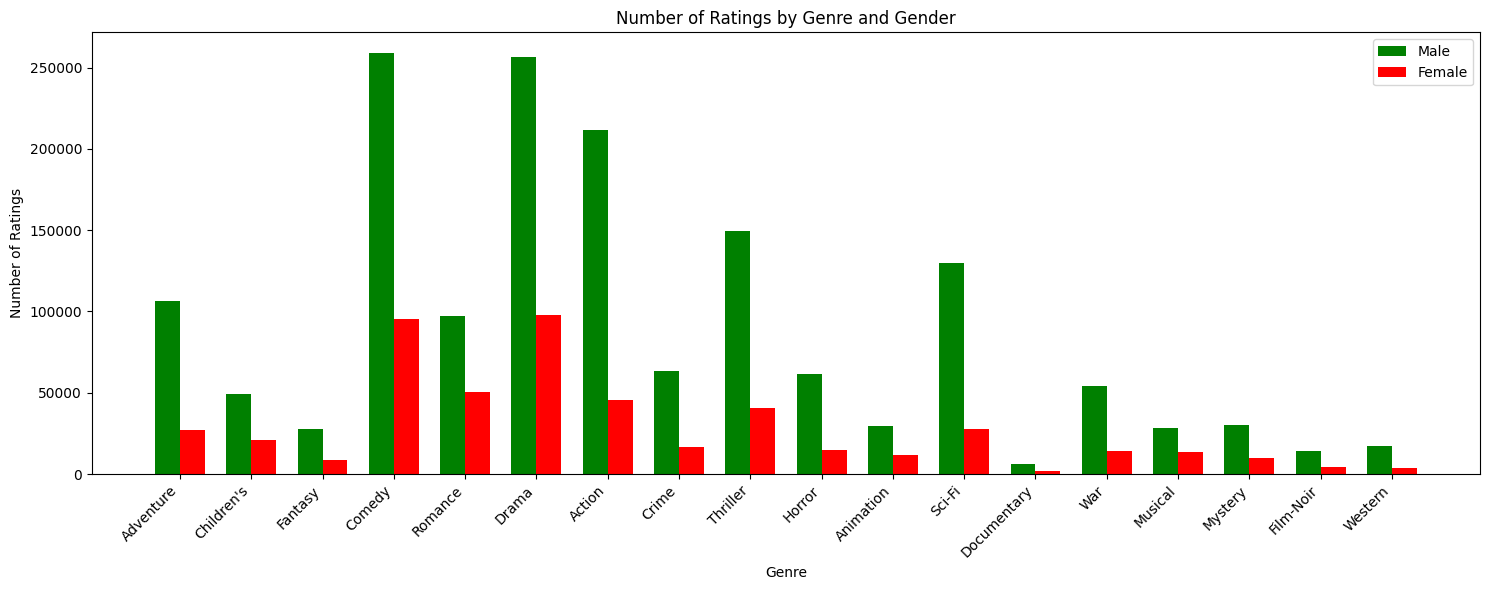

In [ ]:
merged = pd.merge(ratings, users[['userid', 'gender']], on='userid')
final = pd.merge(merged, movie_profile, on='movieid')
genre_ratings = final.groupby('gender').sum().loc[:, 'Adventure':'Western']

fig, ax = plt.subplots(figsize=(15, 6))

bar_width = 0.35
bar_positions = range(len(genre_ratings.columns))

ax.bar(bar_positions, genre_ratings.loc['M'], bar_width, label='Male', color='green')
ax.bar([pos + bar_width for pos in bar_positions], genre_ratings.loc['F'], bar_width, label='Female', color='red')
ax.set_xlabel('Genre')
ax.set_ylabel('Number of Ratings')
ax.set_title('Number of Ratings by Genre and Gender')
ax.set_xticks([pos + bar_width / 2 for pos in bar_positions])
ax.set_xticklabels(genre_ratings.columns, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

**Nhận xét**:
- Có vẻ như nam giới xem nhiều phim hơn so với nữ giới xét trên tất cả các thể loại.
- Cả hai thể loại Comedy và Drama là hai thể loại được xem nhiều nhất ở cả hai giới, vì đây là hai thể loại được nhiều người quan tâm như đã nêu ở biểu đồ tròn trên.
- Documentary là thể loại có số lượng người xem ít nhất.

 f) Vẽ biểu đồ heatmap từ dataframe (genre_data) trên

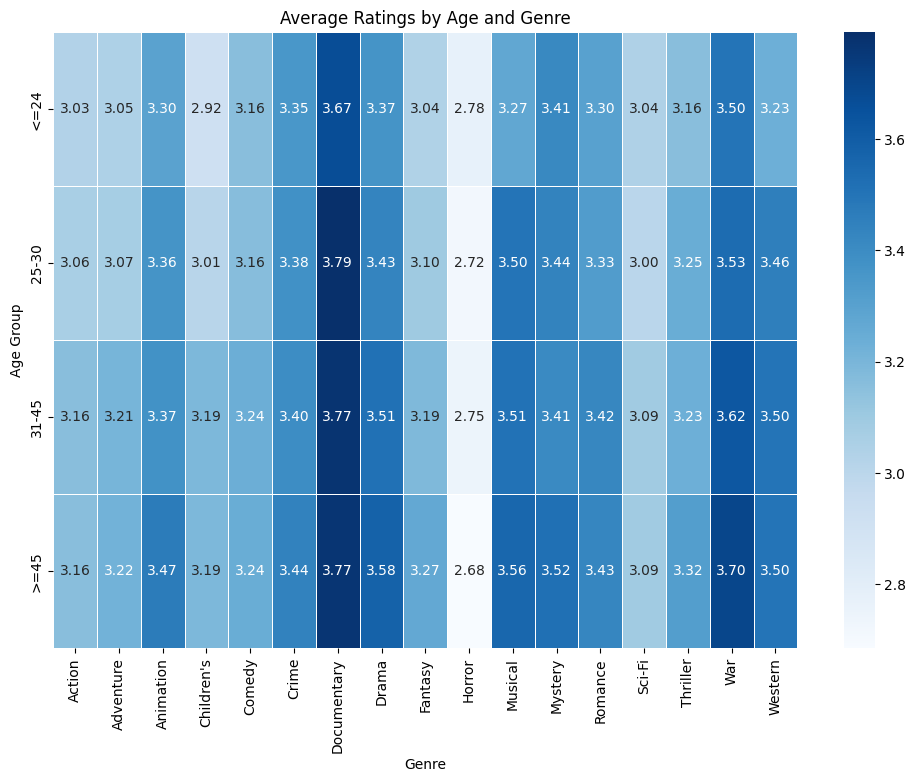

In [ ]:
heatmap_data = genres_ratings.pivot_table(index='age_bin', columns='genre', values='rating', aggfunc='mean')
heatmap_data_filtered = heatmap_data.drop(columns=['Film-Noir'], errors='ignore')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_filtered, cmap='Blues', annot=True, fmt=".2f", linewidths=.5)
plt.title('Average Ratings by Age and Genre')
plt.xlabel('Genre')
plt.ylabel('Age Group')
plt.show()

**Nhận xét**:
- Có vẻ như thể loại Documentary được yêu thích ở mọi độ tuổi. Đặc biệt là độ tuổi sau 25. Nhưng lại trái ngược so với số lượng người xem từ biểu đồ trên.
- Thể loại War, Musical và Drama cũng được nhiều người yêu thích từ độ tuổi sau 30.
- Horror là thể loại kén chọn nhất với người xem với số điểm trung bình khá thấp ở mọi độ tuổi.

# Phần 2: Recommendation System sử dụng Collaborative Filtering và Content Filtering

## 1. Collaborative Filtering

Để triển khai kỹ thuật này, ta sẽ sử dụng thư viện Surprise. Nó cung cấp một bộ các thuật toán tích hợp sẵn thường được sử dụng trong việc phát triển hệ thống đề xuất.

Ý tưởng cơ bản của SVD là phân rã ma trận đánh giá `R` thành tích của ba ma trận: U, Σ và $V^T$.

1. **Ma trận `U`**: Đại diện cho ma trận người dùng, trong đó mỗi hàng biểu diễn một người dùng và các cột đại diện cho các thuộc tính (đặc trưng) của người dùng.

2. **Ma trận `Σ`**: Là ma trận đường chéo với các giá trị đơn giảm dần theo độ lớn. Đây là những giá trị đặc trưng (singular values) và chỉ ra mức độ quan trọng của các thuộc tính. Điều này có thể được biểu diễn bằng ma trận sau:

   \begin{bmatrix}
   \sigma_1 & 0 & \cdots & 0 \\
   0 & \sigma_2 & \cdots & 0 \\
   \vdots & \vdots & \ddots & \vdots \\
   0 & 0 & \cdots & \sigma_k \\
   0 & 0 & \cdots & 0 \\
   \vdots & \vdots & \vdots & \vdots \\
   0 & 0 & \cdots & 0 \\
   \end{bmatrix}

   Trong đó, σ là các giá trị đơn giảm dần.

3. **Ma trận $V^T$**: Đại diện cho ma trận sản phẩm, trong đó mỗi hàng biểu diễn một sản phẩm và các cột đại diện cho các thuộc tính của sản phẩm.

SVD giúp giảm chiều của ma trận đánh giá ban đầu `R` và xấp xỉ nó bằng cách tích của các ma trận `U`, `Σ` và `V^T`:

  $$R ≈ U Σ V^T$$

Khi đã có các ma trận này, ta có thể dự đoán xếp hạng cho các sản phẩm chưa được xem bằng cách tính tích của các vectơ hàng của ma trận người dùng `U` và vectơ cột của ma trận sản phẩm `V`.


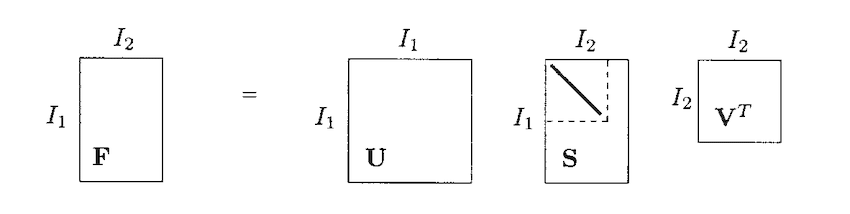


In [ ]:
reader = Reader()

data = Dataset.load_from_df(ratings[['userid', 'movieid', 'rating']], reader)
kf = KFold(n_splits=5)
kf.split(data)

svd = SVD()
trainset = data.build_full_trainset()
svd.fit(trainset)

testset = trainset.build_anti_testset()

In [ ]:
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8748  0.8705  0.8759  0.8747  0.8718  0.8735  0.0020  
MAE (testset)     0.6869  0.6833  0.6875  0.6854  0.6850  0.6856  0.0015  
Fit time          19.67   21.05   22.07   19.89   21.57   20.85   0.93    
Test time         3.78    5.70    4.14    3.52    3.54    4.14    0.81    


{'test_rmse': array([0.8747601 , 0.87053283, 0.87588743, 0.87471595, 0.87181555]),
 'test_mae': array([0.68690393, 0.68327803, 0.68750809, 0.68541166, 0.68498507]),
 'fit_time': (19.668343782424927,
  21.050034284591675,
  22.067359685897827,
  19.888802766799927,
  21.570367336273193),
 'test_time': (3.7753446102142334,
  5.699166297912598,
  4.1414501667022705,
  3.5202488899230957,
  3.543308973312378)}

In [ ]:
predictions = svd.test(testset)

In [ ]:
accuracy.rmse(predictions)

RMSE: 0.6831


0.68314378430675

Ta được RMSE trung bình là 0.6831 cho tập test và 0.8735 cho tập train

Ta thử nghiệm với cặp người dùng user_id = 1 ; movie id = 302; ta được rating xấp xỉ trong khoảng 3-4

In [ ]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=3.886305904873151, details={'was_impossible': False})

## 2. Content-based Filtering

Như đã đề cập ở phần tổng quan, phương pháp này thường được áp dụng trong trường hợp có quá ít hoặc không có đủ dữ liệu rating hoặc khi cần giải quyết cold start problem cho các item mới, tránh để chúng rơi vào tình trạng không thể reach out tới user

Một cách tiếp cận phổ biến trong lọc nội dung là sử dụng vectơ đặc trưng (feature) để biểu diễn các sản phẩm và người dùng.

+ Vectơ Đặc Trưng cho item $i$: Đại diện cho mỗi item i, nó biểu diễn các thuộc tính của sản phẩm đó. Điều này có thể bao gồm các thông tin như thể loại, từ khóa, hoặc bất kỳ thuộc tính nào khác có thể mô tả sản phẩm. Ở dưới đây ta biễu diễn $x_i$ theo thể loại phim (genre)

+ Vectơ Đặc Trưng cho user $u$: Đại diện cho mỗi người dùng u, nó mô tả sở thích và yêu cầu của người dùng trong không gian đặc trưng. Ở dưới đây ta cũng biểu diễn $p_u$ theo thể loại phim, để ý rằng ta có phép nhân element-wise thể hiện ở dòng


```
working_df = movie_profile.mul(user_x_movie.iloc[:,i], axis=0)
user_profile.loc[userIDs[i]] = working_df.mean(axis=0)
```
Tức là thành phần thứ nhất của user $u_i$ (giả sử) sẽ biểu diễn thông qua thể loại 1 của phim (tức là hành động (action)): $$u_{i1} = \frac{1}{n} \sum \text{ genre_action } ⊙ u_i$$ chú ý rằng $u_i$ ban đầu được lấy từ ma trận user-item interaction

Bên cạnh đó, ta sử dụng ma trận TFIDF để phản ánh sự quan trọng của mỗi thể loại trong bất kỳ bộ phim nào (chỉ xem xét thể loại ở giai đoạn này), vector $i$ biễu diễn theo thể loại.

Sau khi có các vectơ đặc trưng này, hệ thống có thể sử dụng chúng để tính độ tương đồng giữa các sản phẩm hoặc giữa người dùng (user) và sản phẩm (item). Điều này có thể được thực hiện bằng cách sử dụng các phương pháp đo lường tương đồng. Ở dưới đây ta thực hiện nhân dot-product giữa hai vector $u$ và $i$. Dựa vào đó, ta có thể đơn giản sắp xếp các bộ phim và đề xuất cho người dùng top N đề xuất đầu tiên

Lọc nội dung là một cách mạnh để đề xuất sản phẩm trong những trường hợp nơi dữ liệu đánh giá có hạn, và thông tin về nội dung là quan trọng.



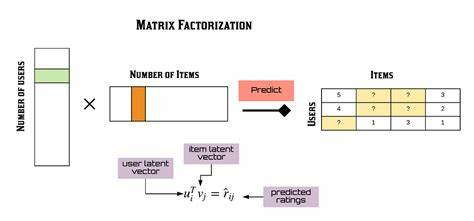


In [ ]:
ratings = ratings.drop(columns = ['timestamp'])
movie_profile = movie_profile.drop(columns=['year'])

# user profile
user_x_movie = pd.pivot_table(ratings, values='rating', index=['movieid'], columns = ['userid'])
user_x_movie.sort_index(axis=0, inplace=True)
userIDs = user_x_movie.columns
user_profile = pd.DataFrame(columns = movie_profile.columns)

for i in range(len(user_x_movie.columns)):
  working_df = movie_profile.mul(user_x_movie.iloc[:,i], axis=0)
  user_profile.loc[userIDs[i]] = working_df.mean(axis=0)

# TFIDF
df = movie_profile.sum()
idf = (len(movies)/df).apply(np.log)
TFIDF = movie_profile.mul(idf.values)

# recommendation
df_predict = pd.DataFrame()

for i in range(len(user_x_movie.columns)):
  working_df = TFIDF.mul(user_profile.iloc[i], axis=1)
  df_predict[user_x_movie.columns[i]] = working_df.sum(axis=1)

In [ ]:
TFIDF

,Adventure,Children's,Fantasy,Comedy,Romance,Drama,Action,Crime,Thriller,Horror,Animation,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
movieid,,,,,,,,,,,,,,,,,,
2,2.618659,2.742645,4.044598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,1.174863,2.109248,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,1.174863,0.000000,0.884474,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,1.174863,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.043516,2.912248,2.065627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.000000,0.000000,0.000000,1.174863,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,0.000000,0.000000,0.000000,0.000000,0.000000,0.884474,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,0.000000,0.000000,0.000000,0.000000,0.000000,0.884474,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ta có đánh giá theo model


In [ ]:
df_predict = df_predict.reset_index()
df_predict

,movieid,1,2,3,4,5,6,7,8,9,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
0,2,6.280783,1.535338,6.493706,5.123863,0.675680,3.741439,3.125496,0.763524,1.132037,...,4.075277,2.630004,4.091001,0.374094,2.014744,1.565430,1.105783,0.935129,2.802654,0.896732
1,3,2.130807,2.265782,3.388925,0.803523,2.124034,6.044882,1.309167,2.426588,2.359797,...,2.328705,3.142901,1.102719,0.279729,2.180445,2.077553,2.072995,5.338744,4.266431,2.117739
2,4,2.747086,2.922331,3.158091,1.052945,2.571713,2.983013,1.405689,3.202493,2.843107,...,2.446046,3.352891,1.575537,0.785143,2.319146,2.404886,2.891069,4.250013,3.116893,2.982948
3,5,1.220936,0.810564,2.603127,0.000000,1.133327,1.946915,0.492684,0.561891,1.074160,...,1.336118,1.996126,0.469945,0.279729,1.212761,1.106064,1.227208,2.702184,2.311518,1.143763
4,6,1.743798,5.804988,4.415820,9.757988,3.008861,1.858715,13.589216,4.995833,4.954404,...,4.053866,1.907789,9.858947,8.238410,2.413928,2.751142,4.603573,0.613055,1.695096,2.568840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3877,3948,1.220936,0.810564,2.603127,0.000000,1.133327,1.946915,0.492684,0.561891,1.074160,...,1.336118,1.996126,0.469945,0.279729,1.212761,1.106064,1.227208,2.702184,2.311518,1.143763
3878,3949,1.526151,2.111766,0.554964,1.052945,1.438386,1.036098,0.913005,2.640602,1.768947,...,1.109928,1.356765,1.105592,0.505413,1.106385,1.298822,1.663861,1.547829,0.805374,1.839185
3879,3950,1.526151,2.111766,0.554964,1.052945,1.438386,1.036098,0.913005,2.640602,1.768947,...,1.109928,1.356765,1.105592,0.505413,1.106385,1.298822,1.663861,1.547829,0.805374,1.839185
3880,3951,1.526151,2.111766,0.554964,1.052945,1.438386,1.036098,0.913005,2.640602,1.768947,...,1.109928,1.356765,1.105592,0.505413,1.106385,1.298822,1.663861,1.547829,0.805374,1.839185


Sử dụng ma trận trên để đề xuất

In [ ]:
def recommender(user_no):
    # user predicted rating to all films
    user_predicted_rating = df_predict[['movieid', df_predict.columns[user_no]]]
    # combine film rating and film detail
    user_rating_film = movies.merge(user_predicted_rating, left_on='movieid', right_on= 'movieid')
    # films already watched by user
    already_watched = ratings[ratings['userid'].isin([user_no])]['movieid']
    # recommendation without films being watched by user
    all_rec = user_rating_film[~user_rating_film.index.isin(already_watched)]
    return all_rec.sort_values(by=user_no, ascending=False, axis=0).iloc[0:10][['movieid', 'title']]

In [ ]:
recommended_movies = recommender(int(3))

In [ ]:
print(recommended_movies)

      movieid                        title
1538     1580                 Men in Black
1178     1197          Princess Bride, The
2335     2405       Jewel of the Nile, The
2336     2406          Romancing the Stone
375       380                    True Lies
1971     2041                    Condorman
2650     2720             Inspector Gadget
679       688         Operation Dumbo Drop
1240     1261  Evil Dead II (Dead By Dawn)
2653     2723                  Mystery Men
